# LeNet

This notebook trains the LeNet-5 neural network on the MNIST database.

#### Imports

In [54]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import random
import re
import time
from typing import Any, Dict
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from models.torch_lenet import TorchLeNet
import data

importlib.reload(data)

SEED = 12

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

ModuleNotFoundError: spec not found for the module 'data'

### Training

In [43]:
_framework = "torch"  #@param ["torch", "jax"]
_val_split = 0.1  #@param
_rotation_degrees = 0  #@param
_crop_padding = 0  #@param
_duplicate_with_augment = False  # Add --duplicate_with_augment flag
_init = "kaiming"  #@param ["orthogonal", "kaiming", "xavier"]
_optimizer = "adamw"  #@param ["sgd", "adam", "adamw"]
_activation = "relu"  #@param ["relu", "tanh", "sigmoid"]
_lr = 3e-4  #@param
_seed = SEED  #@param


model_path = f'models/ckpts/lenet_{_framework}_{_val_split}_{_rotation_degrees}_{_crop_padding}_{_duplicate_with_augment}_{_init}_{_optimizer}_{_activation}_{_lr}_{_seed}.pth'
print(model_path)

models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_relu_0.0003_12.pth


In [41]:
! python src/train.py --framework={_framework} \
    --val_split={_val_split} \
    --rotation_degrees={_rotation_degrees} \
    --crop_padding={_crop_padding} \
    {"--duplicate_with_augment" if _duplicate_with_augment else ""} \
    --init={_init} \
    --optimizer={_optimizer} \
    --activation={_activation} \
    --lr={_lr} \
    --seed={_seed} 

---------------------------------------------
Framework:                  torch
Validation Split:           0.1
Rotation Degrees:           0
Crop Padding:               0
Duplicate with Augment:     False
Init method:                kaiming
Optimizer:                  adamw
Activation:                 relu
Learning Rate:              0.0003
Random Seed:                12
---------------------------------------------
Train: Dataset MNIST
    Number of datapoints: 54000

Val: Dataset MNIST
    Number of datapoints: 6000
Test: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )

Parameters:  61706
Epoch 1 | 25.63s | Train Loss: 0.8489, Val Loss: 0.3471
Epoch 2 | 25.39s | Train Loss: 0.2737, Val Loss: 0.2221
Epoch 3 | 25.10s | Train Loss: 0.1826, Val Loss: 0.1675
Epoch 4 | 25.27s | Train Loss: 0.1348, Val L

### Evaluation

In [47]:
from models.torch_lenet import TorchLeNet

print(f'Loading model at: {model_path}')

def get_model_params(model_path: str) -> Dict[str, Any]:
    model_params = model_path.replace(".pth", "").split("_")
    assert len(model_params) == 11
    
    params_dict = {}
    params_dict["framework"] = model_params[1]
    params_dict["val_split"] = float(model_params[2])
    params_dict["rotation_degrees"] = int(model_params[3])
    params_dict["crop_padding"] = int(model_params[4])
    params_dict["duplicate_with_augment"] = model_params[5]
    params_dict["init"] = model_params[6]
    params_dict["optimizer"] = model_params[7]
    params_dict["activation"] = model_params[8]
    params_dict["lr"] = float(model_params[9])
    params_dict["seed"] = int(model_params[10])

    return params_dict
    
# Load model
model_params = get_model_params(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lenet5 = TorchLeNet(act_fn=model_params["activation"], init=model_params["init"]).to(device)
lenet5.load_state_dict(torch.load(model_path))

Loading model at: models/ckpts/lenet_torch_0.1_0_0_False_kaiming_adamw_relu_0.0003_12.pth


<All keys matched successfully>

In [48]:
_train_dataset, test_dataset, _val_dataset = data.get_MNIST()

test_x = test_dataset.data.unsqueeze(1).float()
test_y = test_dataset.targets

lenet5.eval()
with torch.no_grad():
    test_x, test_y = test_x.to(device), test_y.to(device)
    logits = lenet5(test_x)
    test_preds = logits.argmax(axis=1)
    accuracy = (test_preds == test_y).sum() / len(test_y)

print(f'Test Set Accuracy: {100 * accuracy:.2f}%')

Train: Dataset MNIST
    Number of datapoints: 54000

Val: Dataset MNIST
    Number of datapoints: 6000
Test: Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[tensor(0.1307)], std=[tensor(0.3081)])
           )

Test Set Accuracy: 95.02%


### Ablations

### Interpretability

#### Saliency Maps

In [105]:
def saliency_map(model, x, y, grad_times_input=False):
    """
    Returns a saliency map (∂ score_y / ∂ x) for a given model, input, and label.

    Args:
        model (nn.Module): Classifier
        x (tensor): CxHxW normalized image
        y (int): Class index (target label)
        grad_times_input (bool): If true, returns a gradient x input saliency map. (input * ∂ score_y / ∂ x)

    Returns:
        saliency (np.ndarray): Saliency map.
    """
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = x.clone().detach().to(device)
    if x.ndim == 3:      
        x = x.unsqueeze(0)  # Add batch dim if needed
    y = torch.tensor([int(y)], device=device)

    x.requires_grad_(True)  # Enable input gradients
    model.zero_grad(set_to_none=True)  # Set gradients to 0

    with torch.enable_grad():
        logits = model(x)
        score_y = logits.gather(1, y.view(-1,1)).squeeze()
        score_y.backward()

    saliency = x.grad
    if (grad_times_input):
        saliency = (saliency * x.detach())
    saliency = saliency.detach().abs().squeeze()
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)  # Normalize to [0,1] for visualization
    return saliency.cpu()

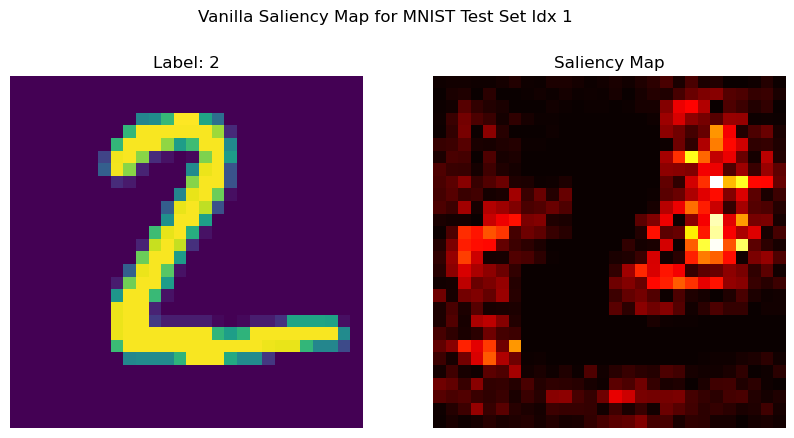

In [108]:
test_idx = 1  #@param

x, y = sal = test_x[test_idx], test_y[test_idx]

sal = saliency_map(lenet5, x, y)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Vanilla Saliency Map for MNIST Test Set Idx {test_idx}')
ax[0].imshow(x.squeeze()); ax[0].set_title(f'Label: {y}'); ax[0].axis("off");
ax[1].imshow(sal.numpy(), cmap="hot"); ax[1].set_title(f'Saliency Map'); ax[1].axis("off"); plt.show()

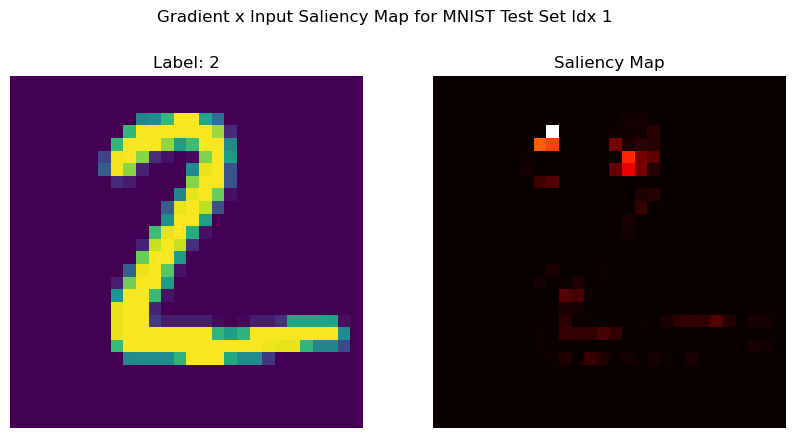

In [109]:
# Notice how the digit pixels have the lowest gradient.
# In an attempt to highlight which parts of the writing contribute to the class, we can visualize Gradient × Input
inp_sal = saliency_map(lenet5, x, y, grad_times_input=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle(f'Gradient x Input Saliency Map for MNIST Test Set Idx {test_idx}')
ax[0].imshow(x.squeeze()); ax[0].set_title(f'Label: {y}'); ax[0].axis("off");
ax[1].imshow(inp_sal.numpy(), cmap="hot"); ax[1].set_title(f'Saliency Map'); ax[1].axis("off"); plt.show()

#### GradCAM

#### Sparse Autoencoders (SAEs)

### Adversarial Examples